## Special topics: Wrapping C and FORTRAN code

Wrapping C and FORTRAN code is one of the most powerful ways to extend python. That is how packages like `numpy`, `matplotlib`, `basemap` (in particular `proj4`), and `netCDF` all work. They wrap existing C and FORTRAN packages by linking into compiled code.

There are many ways to wrap code. You can get a good overview of many of the options and relative speeds [here](http://scipy.github.io/old-wiki/pages/PerformancePython).

### scipy.weave

Let's begin with a very simple example of wrapping a few lines of C using `scipy.weave`. This function compiles C code on the fly, and lets you execute the compiled code at C speeds.

[0, 1, 0, 1]

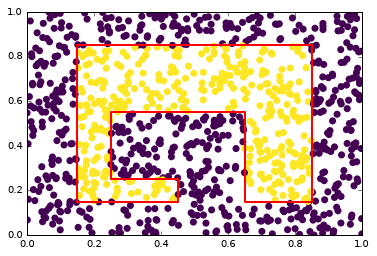

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.weave as weave


def npnpoly(verts,points):
    verts = verts.astype(np.float64)
    points = points.astype(np.float64)

    xp = np.ascontiguousarray(verts[:,0])
    yp = np.ascontiguousarray(verts[:,1])
    x = np.ascontiguousarray(points[:,0])
    y = np.ascontiguousarray(points[:,1])
    out = np.empty(len(points),dtype=np.uint8)

    code = """
    /* Code from:
       http://www.ecse.rpi.edu/Homepages/wrf/Research/Short_Notes/pnpoly.html
    
       Copyright (c) 1970-2003, Wm. Randolph Franklin
    
       Permission is hereby granted, free of charge, to any person
       obtaining a copy of this software and associated documentation
       files (the "Software"), to deal in the Software without
       restriction, including without limitation the rights to use, copy,
       modify, merge, publish, distribute, sublicense, and/or sell copies
       of the Software, and to permit persons to whom the Software is
       furnished to do so, subject to the following conditions:
    
        1. Redistributions of source code must retain the above
             copyright notice, this list of conditions and the following
             disclaimers.
        2. Redistributions in binary form must reproduce the above
             copyright notice in the documentation and/or other materials
             provided with the distribution.
        3. The name of W. Randolph Franklin may not be used to endorse
             or promote products derived from this Software without
             specific prior written permission. 
    
       THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
       EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
       MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
       NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
       BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
       ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
       CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
       SOFTWARE. */
       
    int i,j,n;
    unsigned int c;
    int nr_verts = Nxp[0];
    for (n = 0; n < Nx[0]; n++) {
        c = 0;
        for (i = 0, j = nr_verts-1; i < nr_verts; j = i++) {
            if ((((yp(i)<=y(n)) && (y(n)<yp(j))) ||
                 ((yp(j)<=y(n)) && (y(n)<yp(i)))) &&
                (x(n) < (xp(j) - xp(i)) * (y(n) - yp(i)) / (yp(j) - yp(i)) + xp(i)))

            c = !c;
        }
    out(n) = c;
    }
    """
    weave.inline(code, ['xp','yp','x','y','out'],
                 type_converters=weave.converters.blitz)
    return out

verts = np.array([[0.15,0.15],
                  [0.25,0.15],
                  [0.45,0.15],
                  [0.45,0.25],
                  [0.25,0.25],
                  [0.25,0.55],
                  [0.65,0.55],
                  [0.65,0.15],
                  [0.85,0.15],
                  [0.85,0.85],
                  [0.15,0.85],
                  [0.15,0.15]])

trial_points = np.random.rand(1000, 2)
out = npnpoly(verts, trial_points)

plt.plot(verts[:, 0], verts[:, 1], '-r', lw=2)
plt.scatter(trial_points[:, 0], trial_points[:, 1], 50, out, vmin=0, vmax=1, edgecolor='none', cmap='viridis')
plt.axis([0, 1, 0, 1])

### f2py

Another powerful way to compile code is using the script `f2py`. If I have a file `test_fort.f`, I can compile this file as a module, where the FORTRAN functions defined in the will be exposed as functions contained in the module. Compile the code with the command (at a command line, not at a python prompt)

    $ f2py -c -m testmod test_fort.f

The `-c` flag says to compile the code. The `-m testmod` option specifies the module name. A file named `testmod.so` will be created, which containes the compiled fortran code. You can import this code using the command (at a python prompt)

    >>> import testmod
    
Many FORTRAN subroutines from LAPACK are wrapped and exposed in `numpy` using `f2py`.

## Cython

One of the most common ways to create new (fast) code, and wrap C libraries is to use Cython. This is used in `netCDF4` and `proj4`, for example. Cython is designed to be compiled as part of a larger package, either linking the existing libraries or compiling new Cython code. This is beyond the scope of this class, but we can see how this might be used by using the `pyximport` library, which will compile Cython (and regular Python) code for added speed.

Cython code looks a lot like regular Python, but the variables in the code are declared so that the compiler does not need to constantly check for the type of the variable before doing operations. This is one way Cython code is more efficient, which translates directly into speed improvements.

To use this, suppose you have a file named [cprimes.pyx]` (see `materials/wrapping/cython/cprimes.pyx`). You would first import and initiate pyximport:

    import pyximport; pyximport.install()

Then, you would import the `.pyx` file as you would a normal module. The compilation of the `.pyx` file happens behind the scenes, and the compiled module is imported:

    import cprimes

In [2]:
import sys
sys.path.insert(0, 'wrapping/cython')

import pyximport; pyximport.install()
import cprimes

In [3]:
%timeit cprimes.primes(1000)

1000 loops, best of 3: 1.88 ms per loop


Compare this to the python only version of this code:

In [35]:
import pyprimes
%timeit pyprimes.primes(1000)

1 loops, best of 3: 272 ms per loop
